In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
	accuracy_score,
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	roc_curve,
	auc,
	classification_report
)
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
def carregar_dados_csv(file):

	try:
		
		df_completo = pd.read_csv(file)

		return df_completo

	except FileNotFoundError:

		print(f"Erro: O arquivo '{file}' não foi encontrado.")
		print("Rode o ZeaMays para gerar o arquivo CSV.")
		return None

	except KeyError as e:

		print(f"Erro: Uma ou mais colunas não encontradas no arquivo: {e}")
		return None

	except Exception as e:

		print(f"Ocorreu um erro inesperado: {e}")
		return None

In [3]:
metricas = "df_metricas_seq_final.csv"

df_metricas = carregar_dados_csv(metricas)

if df_metricas is not None:
	print("\nHead do DataFrame:")
	print(df_metricas.shape)
	print(df_metricas.head())

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_9392\4259128047.py:5: DtypeWarning: Columns (48,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_completo = pd.read_csv(file)



Head do DataFrame:
(107571, 5779)
   Chr SourceAnnotation                                    COS      Start  \
0    5           APTEdb  Class II subclass 2/Helitron/Helitron   28903351   
1    3           APTEdb  Class II subclass 2/Helitron/Helitron    2184634   
2    7           APTEdb  Class II subclass 2/Helitron/Helitron   82856122   
3    1           APTEdb  Class II subclass 2/Helitron/Helitron  185134318   
4    8           APTEdb  Class II subclass 2/Helitron/Helitron    2261318   

         End Score Strand Phase  \
0   28903636     .      -     .   
1    2185235     .      -     .   
2   82857584     .      +     .   
3  185151509     .      -     .   
4    2261604     .      +     .   

                                          Attributes  \
0  TE-Score=0.285;Software=RepeatModeler;Length=2...   
1  TE-Score=0.428;Software=RepeatMasker;Length=60...   
2  TE-Score=0.428;Software=RepeatModeler;Length=1...   
3  TE-Score=0.714;Software=HelitronScanner;Length...   
4  TE-Score

In [4]:
remover_colunas = ["Chr", "SourceAnnotation", "Start", "End", "Score", "Strand", "Phase", "Attributes", "label"]

df_metricas = df_metricas.drop(columns=remover_colunas)

print("\nDataFrame após remover colunas:")
print(df_metricas.shape)
print(df_metricas.head())


DataFrame após remover colunas:
(107571, 5770)
                                     COS  ZMays/Agrup\anf_fourier_average  \
0  Class II subclass 2/Helitron/Helitron                        22.959990   
1  Class II subclass 2/Helitron/Helitron                        44.649242   
2  Class II subclass 2/Helitron/Helitron                       113.012818   
3  Class II subclass 2/Helitron/Helitron                      1109.133954   
4  Class II subclass 2/Helitron/Helitron                        25.080989   

   ZMays/Agrup\anf_fourier_median  ZMays/Agrup\anf_fourier_maximum  \
0                        1.680885                     5.884405e+03   
1                        1.594868                     2.543616e+04   
2                        4.545350                     1.550335e+05   
3                       10.007322                     1.881748e+07   
4                        1.818602                     6.515580e+03   

   ZMays/Agrup\anf_fourier_minimum  ZMays/Agrup\anf_fourier_peak  \


In [5]:
coluna_alvo = 'COS'

In [6]:
def verfica_unique (df, coluna):
	
	if coluna in df.columns:

		contagem_valores = df[coluna].value_counts()

		print(f"Contagem de cada valor único na coluna '{coluna}':")
		print(contagem_valores)

		valores_unicos = df[coluna].unique()
		print(f"\nValores únicos na coluna '{coluna}':")
		print(valores_unicos)

		numero_de_valores_unicos = df[coluna].nunique()
		print(f"\nA coluna '{coluna}' possui {numero_de_valores_unicos} valores únicos distintos.")

	else:
		print(f"A coluna '{coluna}' não foi encontrada no DataFrame.")
		print("Colunas disponíveis:", df.columns.tolist())

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
Class I/LTR/Gypsy                         20992
Class II subclass 2/Helitron/Helitron     16337
Class II subclass 2/MITE/MITE             15126
Class I/LINE/L1                           11217
Class I/LTR/Copia                         11181
Class I/SINE/tRNA                          3677
Class II subclass 1/TIR/PIF-Harbinger      3460
Class I/LTR/LARD                           3232
Class I/LTR/Unknown                        2940
Class II subclass 1/TIR/hAT                2712
Class II subclass 1/TIR/Harbinger          2244
Class II subclass 1/TIR/Unknown            1925
Class II subclass 1/TIR/CMC-EnSpm          1573
Class I/LINE/Unknown                       1531
Class II subclass 1/TIR/EnSpm-CACTA        1477
Class II subclass 1/TIR/MuDR               1435
Class II subclass 1/TIR/hAT-Ac             1434
Class I/SINE/Unknown                       1333
Class II subclass 1/TIR/MuLE-MuDR           954
Class II subclass 1/TIR/TcMar-Stowaway

In [7]:
def extrair_elemento_transponivel(texto):
  
	try:
		return texto.split('/')[1]
	except IndexError:
		return
	
df_metricas[coluna_alvo] = df_metricas[coluna_alvo].apply(extrair_elemento_transponivel)

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38795
TIR         18995
Helitron    16337
MITE        15126
LINE        13046
SINE         5272
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [8]:
ocorrencia = 1

contagens = df_metricas[coluna_alvo].value_counts()

valores_para_manter = contagens[contagens > ocorrencia].index

df_metricas = df_metricas[df_metricas[coluna_alvo].isin(valores_para_manter)]

verfica_unique(df_metricas, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38795
TIR         18995
Helitron    16337
MITE        15126
LINE        13046
SINE         5272
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [9]:
df_metricas.shape

(107571, 5770)

In [10]:
# Defina todos os prefixos que você quer remover em uma tupla
prefixos_para_remover = (r'ZMays/Agrup\chaos_', r'ZMays/Agrup\anf_fourier_class')
sufixo_para_remover = '_class'

colunas_para_remover = [
    col for col in df_metricas.columns
    if col.startswith(prefixos_para_remover) or col.endswith(sufixo_para_remover)
]

df_metricas = df_metricas.drop(columns=colunas_para_remover)

print("Total de colunas removidas:", len(colunas_para_remover))
print("Nomes das colunas removidas:", colunas_para_remover) # Opcional, pode ser uma lista grande
print("\nFormato do DataFrame Original:", df_metricas.shape)
print("Novo formato do DataFrame Limpo:", df_metricas.shape)
print("\nPrimeiras linhas do DataFrame limpo:")
print(df_metricas.head())

Total de colunas removidas: 51
Nomes das colunas removidas: ['ZMays/Agrup\\anf_fourier_class', 'ZMays/Agrup\\chaos_signal_classic_average', 'ZMays/Agrup\\chaos_signal_classic_median', 'ZMays/Agrup\\chaos_signal_classic_maximum', 'ZMays/Agrup\\chaos_signal_classic_minimum', 'ZMays/Agrup\\chaos_signal_classic_peak', 'ZMays/Agrup\\chaos_signal_classic_none_levated_peak', 'ZMays/Agrup\\chaos_signal_classic_sample_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_population_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_percentile15', 'ZMays/Agrup\\chaos_signal_classic_percentile25', 'ZMays/Agrup\\chaos_signal_classic_percentile50', 'ZMays/Agrup\\chaos_signal_classic_percentile75', 'ZMays/Agrup\\chaos_signal_classic_amplitude', 'ZMays/Agrup\\chaos_signal_classic_variance', 'ZMays/Agrup\\chaos_signal_classic_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_semi_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_coefficient_of_variation', 'ZMays/Agrup\\chaos_signa

In [11]:
# pd.set_option('display.max_columns', None)

print(df_metricas.columns.tolist())

# coluna_nome = df_metricas['ZMays/Agrup\\anf_fourier_class']
# print("Coluna :")
# print(coluna_nome)

['COS', 'ZMays/Agrup\\anf_fourier_average', 'ZMays/Agrup\\anf_fourier_median', 'ZMays/Agrup\\anf_fourier_maximum', 'ZMays/Agrup\\anf_fourier_minimum', 'ZMays/Agrup\\anf_fourier_peak', 'ZMays/Agrup\\anf_fourier_none_levated_peak', 'ZMays/Agrup\\anf_fourier_sample_standard_deviation', 'ZMays/Agrup\\anf_fourier_population_standard_deviation', 'ZMays/Agrup\\anf_fourier_percentile15', 'ZMays/Agrup\\anf_fourier_percentile25', 'ZMays/Agrup\\anf_fourier_percentile50', 'ZMays/Agrup\\anf_fourier_percentile75', 'ZMays/Agrup\\anf_fourier_amplitude', 'ZMays/Agrup\\anf_fourier_variance', 'ZMays/Agrup\\anf_fourier_interquartile_range', 'ZMays/Agrup\\anf_fourier_semi_interquartile_range', 'ZMays/Agrup\\anf_fourier_coefficient_of_variation', 'ZMays/Agrup\\anf_fourier_skewness', 'ZMays/Agrup\\anf_fourier_kurtosis', 'ZMays/Agrup\\complex_networks_agrupado_avg_betweenness.1-mer', 'ZMays/Agrup\\complex_networks_agrupado_avg_degree.1-mer', 'ZMays/Agrup\\complex_networks_agrupado_assortativity_degree.1-mer',

In [12]:
df_metricas.shape

(107571, 5719)

In [13]:
def random_forest(X_train, y_train, feature_names, caminho_salvar):
    
    print("--- Treinando o Modelo Random Forest ---")
    modelo_rf = RandomForestClassifier(n_estimators=120, class_weight='balanced', random_state=42, n_jobs=-1)
    modelo_rf.fit(X_train, y_train)
    
    print(f"Salvando o modelo em: {caminho_salvar}")
    joblib.dump(modelo_rf, caminho_salvar)
    print("Modelo Random Forest treinado e salvo com sucesso!")

def random_forest_optuna(X_train, y_train, X_test, y_test, feature_names, caminho_salvar, n_trials=100):
    
    print("--- Otimizando e Treinando o Modelo Random Forest com Optuna ---")
    
    def objetivo(trial):
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'random_state': 42,
            'n_jobs': -1
        }
        
        modelo_rf = RandomForestClassifier(**params)
        modelo_rf.fit(X_train, y_train)
        y_pred = modelo_rf.predict(X_test)
        return accuracy_score(y_test, y_pred)

    estudo = optuna.create_study(direction='maximize')
    estudo.optimize(objetivo, n_trials=n_trials)
    
    melhores_params = estudo.best_params
    print(f"Melhores hiperparâmetros encontrados: {melhores_params}")
    
    modelo_rf_optuna = RandomForestClassifier(**melhores_params, random_state=42, n_jobs=-1)
    modelo_rf_optuna.fit(X_train, y_train)
    
    print(f"Salvando o modelo em: {caminho_salvar}")
    joblib.dump(modelo_rf_optuna, caminho_salvar)
    print("Modelo Random Forest (Optuna) treinado e salvo com sucesso!")

def xgboost(X_train, y_train, feature_names, caminho_salvar):
    
    print("--- Treinando o Modelo XGBoost ---")
    num_classes = len(np.unique(y_train))
    params_xgb = {
        'n_estimators': 120,
        'learning_rate': 0.1,
        'max_depth': 4,
        'random_state': 42,
        'use_label_encoder': False,
    }
    if num_classes > 2:
        params_xgb['objective'] = 'multi:softprob'
        params_xgb['eval_metric'] = 'mlogloss'
    else:
        params_xgb['objective'] = 'binary:logistic'
        params_xgb['eval_metric'] = 'logloss'
        
    modelo_xgb = XGBClassifier(**params_xgb)
    modelo_xgb.fit(X_train, y_train)
    
    print(f"Salvando o modelo em: {caminho_salvar}")
    joblib.dump(modelo_xgb, caminho_salvar)
    print("Modelo XGBoost treinado e salvo com sucesso!")

['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']
[0 1 2 3 4 5]


In [14]:
nome_coluna_alvo = 'COS'

# df_metricas = df_metricas.copy()

# Amostragem de frac% do DataFrame filtrado para um pseudo-treinamento
# df_metricas = df_metricas.sample(frac=0.8, random_state=42)

if nome_coluna_alvo not in df_metricas.columns:

	print(f"ERRO: Coluna alvo '{nome_coluna_alvo}' não encontrada no DataFrame!")
	
else:

	y_original = df_metricas[nome_coluna_alvo]
	X_original = df_metricas.drop(columns=[nome_coluna_alvo])
	
	print(f"\nVariável Alvo Selecionada: '{nome_coluna_alvo}' (Multiclasse)")
	print("-" * 50)

	# Codificar Features Categóricas em X (One-Hot Encoding)
	colunas_categoricas_X = X_original.select_dtypes(include=['object', 'category']).columns
	X_codificado = pd.get_dummies(X_original, columns=colunas_categoricas_X, drop_first=True, sparse=True)
	feature_names = X_codificado.columns.tolist()

	print("\nFeatures (X) após One-Hot Encoding (primeiras linhas):")
	print(X_codificado.head())
	print(f"Número de features após encoding: {X_codificado.shape[1]}")
	print("-" * 50)

	# Codificar Variável Alvo (y) para formato numérico 0..N-1
	le = LabelEncoder()
	y_codificada = le.fit_transform(y_original) # Converte strings/categorias para 0, 1, 2...

	class_names = le.classes_ # Salva os nomes originais das classes
	
	print(f"\nCodificação da Variável Alvo '{nome_coluna_alvo}':")
	print("Classes originais:", le.classes_)
	print("Classes codificadas (únicas):", np.unique(y_codificada))
	print("Alvo (y) após codificação (primeiras ocorrências):", y_codificada[:5])
	print("-" * 50)

	# Dividir em Dados de Treino e Teste
	try:

		X_train, X_test, y_train, y_test = train_test_split(X_codificado, y_codificada, test_size=0.25, random_state=42, stratify=y_codificada)

	except ValueError:

		print("Aviso: Não foi possível usar 'stratify'. Tentando sem.")

		X_train, X_test, y_train, y_test = train_test_split(X_codificado, y_codificada, test_size=0.25, random_state=42)

	print(f"\nDimensões dos conjuntos de treino/teste estabelecidas.")
	print("-" * 50)


Variável Alvo Selecionada: 'COS' (Multiclasse)
--------------------------------------------------

Features (X) após One-Hot Encoding (primeiras linhas):
   ZMays/Agrup\anf_fourier_average  ZMays/Agrup\anf_fourier_median  \
0                        22.959990                        1.680885   
1                        44.649242                        1.594868   
2                       113.012818                        4.545350   
3                      1109.133954                       10.007322   
4                        25.080989                        1.818602   

   ZMays/Agrup\anf_fourier_maximum  ZMays/Agrup\anf_fourier_minimum  \
0                     5.884405e+03                         0.002714   
1                     2.543616e+04                         0.020863   
2                     1.550335e+05                         0.002981   
3                     1.881748e+07                         0.002313   
4                     6.515580e+03                         0.003427  

In [15]:
# Caminhos para salvar os modelos
caminho_rf = "models/modelo_rf.joblib"
caminho_rf_optuna = "models/modelo_rf_optuna.joblib"
caminho_xgb = "models/modelo_xgb.joblib"

os.makedirs("models", exist_ok=True)

# Treinar e salvar cada modelo
random_forest(X_train, y_train, feature_names, caminho_rf)
# random_forest_optuna(X_train, y_train, X_test, y_test, feature_names, caminho_rf_optuna)
# xgboost(X_train, y_train, feature_names, caminho_xgb)

--- Treinando o Modelo Random Forest ---
Salvando o modelo em: models/modelo_rf.joblib
Modelo Random Forest treinado e salvo com sucesso!


--- Carregando e Avaliando: Random Forest ---

Relatório de Classificação:
              precision    recall  f1-score   support

    Helitron       0.63      0.17      0.27      4084
        LINE       0.52      0.05      0.09      3261
         LTR       0.56      0.76      0.64      9699
        MITE       0.25      0.32      0.28      3782
        SINE       0.76      0.13      0.22      1318
         TIR       0.28      0.42      0.34      4749

    accuracy                           0.43     26893
   macro avg       0.50      0.31      0.31     26893
weighted avg       0.48      0.43      0.39     26893



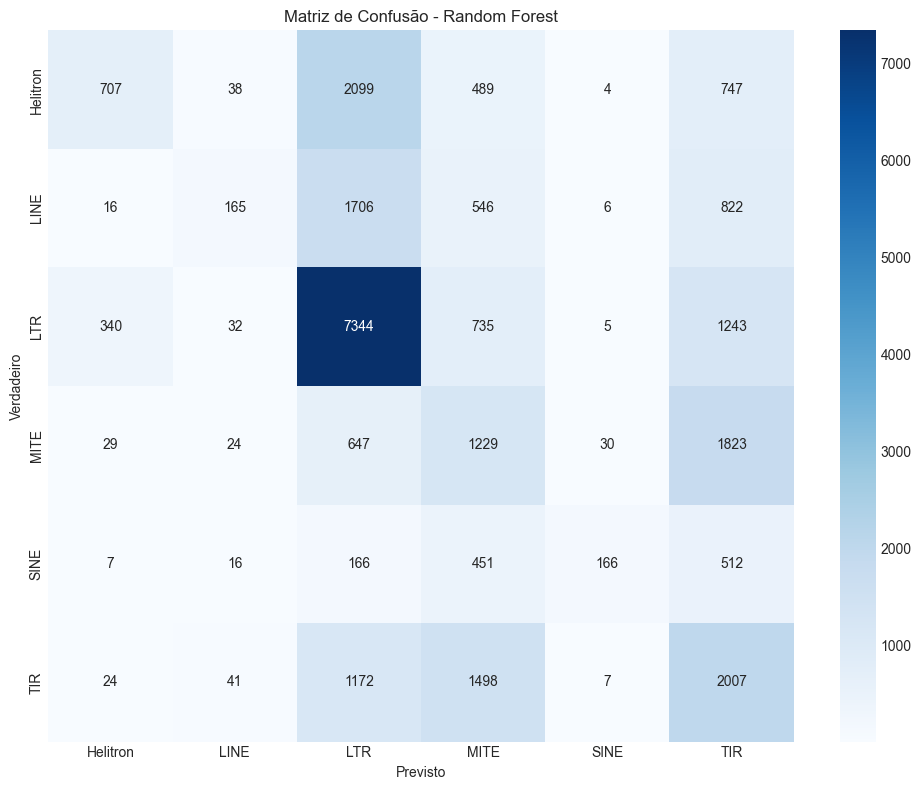

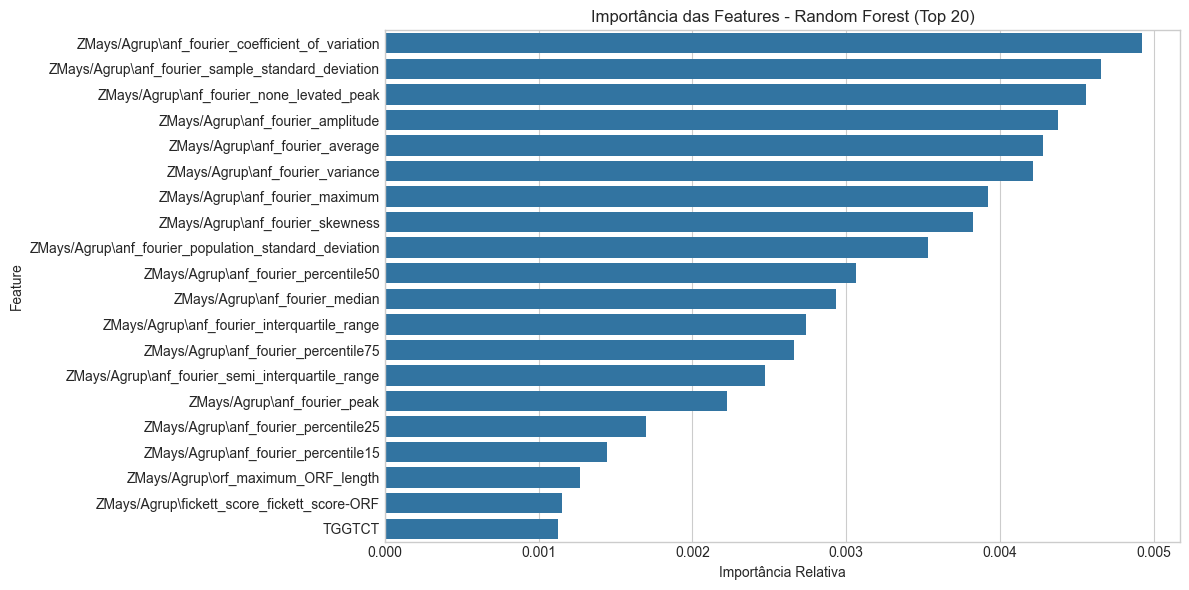

In [16]:
def carregar_e_plotar_modelos(caminhos_modelos, X_test, y_test, class_names, feature_names):
  
    for nome_modelo, caminho in caminhos_modelos.items():
        print(f"--- Carregando e Avaliando: {nome_modelo} ---")
        
        try:
            modelo_carregado = joblib.load(caminho)
        except FileNotFoundError:
            print(f"Arquivo do modelo não encontrado em: {caminho}")
            continue

        y_pred = modelo_carregado.predict(X_test)

        # Relatório de Classificação
        print("\nRelatório de Classificação:")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Matriz de Confusão
        plt.style.use('seaborn-v0_8-whitegrid')
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Matriz de Confusão - {nome_modelo}')
        plt.ylabel('Verdadeiro')
        plt.xlabel('Previsto')
        plt.tight_layout()
        plt.show()

        # Importância das Features
        if hasattr(modelo_carregado, 'feature_importances_'):
            importances = modelo_carregado.feature_importances_
            indices = np.argsort(importances)[::-1]
            num_features_to_plot = min(len(feature_names), 20)
            
            plt.figure(figsize=(12, max(6, num_features_to_plot * 0.3)))
            plt.title(f"Importância das Features - {nome_modelo} (Top {num_features_to_plot})")
            sns.barplot(x=importances[indices][:num_features_to_plot],
                        y=[feature_names[i] for i in indices[:num_features_to_plot]])
            plt.xlabel("Importância Relativa")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()

# Dicionário com os nomes dos modelos e os caminhos onde foram salvos
caminhos_dos_modelos = {
    "Random Forest": "models/modelo_rf.joblib"
    # "Random Forest (Optuna)": "models/modelo_rf_optuna.joblib",
    # "XGBoost": "models/modelo_xgb.joblib"
}

# Carregar os modelos e gerar os gráficos
carregar_e_plotar_modelos(caminhos_dos_modelos, X_test, y_test, class_names, feature_names)